In [2]:
import pandas as pd
import sys
sys.path.append("../../src/")
import micromet
from micromet import simulate_alfalfa_height_multi_field
from micromet import AlfalfaHeightParams

In [19]:
weather = pd.read_csv("PRISM_myton_celsius.csv", parse_dates=["Date"], index_col="Date")


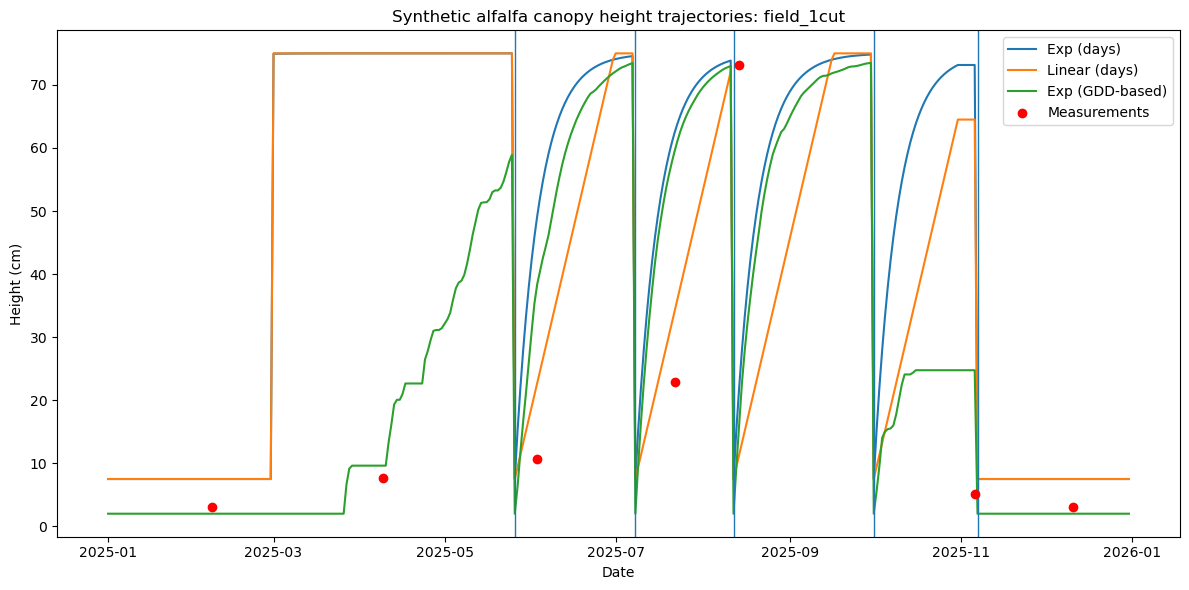

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

weather = pd.read_csv("PRISM_myton_celsius_2025.csv", parse_dates=["Date"], index_col="Date")

# --- Synthetic cut schedules (1–4 cuts) ---
cut_schedules = {
    "field_1cut":  ["05/26/2025","07/08/2025","08/12/2025","10/1/2025","11/7/2025"],
}


# --- Synthetic modeling period (one year) ---
dates = pd.date_range("2025-01-01", "2025-12-31", freq="D")
doy = dates.dayofyear.to_numpy()

# Same weather for all fields in this demo
weather_by_field = {k: weather for k in cut_schedules.keys()}

# --- Define model parameter sets ---
# Day-based exponential
p_exp_days = AlfalfaHeightParams(
    h_resid_cm=7.5,
    h_max_cm=75.0,
    rate=0.12,        # k (day^-1) for 'exp' model; tune as needed
    model="exp",
    time_mode="days",
    dormancy_mode="doy",
)

# Day-based linear (simple)
p_lin_days = AlfalfaHeightParams(
    h_resid_cm=7.5,
    h_max_cm=75.0,
    rate=1.9,         # r (cm/day)
    model="linear",
    time_mode="days",
    dormancy_mode="doy",
)

# GDD-based exponential (thermal time)
p_exp_gdd = AlfalfaHeightParams(
    h_resid_cm=2.0,
    h_max_cm=75.0,
    rate=0.009,       # k_gdd (per GDD); tune as needed
    model="exp",
    time_mode="gdd",
    tbase_c= 10.0,
    tcap_c=30,      # optional cap (e.g., 30C) if you want
    dormancy_mode="temp",
    tmean_col="tmean_c",
)

# Run simulations
df_exp_days = simulate_alfalfa_height_multi_field(
    dates=dates,
    cut_dates_by_field=cut_schedules,
    default_params=p_exp_days,
    weather_by_field=weather_by_field,
)

df_lin_days = simulate_alfalfa_height_multi_field(
    dates=dates,
    cut_dates_by_field=cut_schedules,
    default_params=p_lin_days,
    weather_by_field=weather_by_field,
)

df_exp_gdd = simulate_alfalfa_height_multi_field(
    dates=dates,
    cut_dates_by_field=cut_schedules,
    default_params=p_exp_gdd,
    weather_by_field=weather_by_field,
)

meas_dates = ['2/7/2025','4/9/2025','6/3/2025','7/22/2025','8/14/2025','11/6/2025','12/11/2025']
meas_values = [0.1, 0.25, 0.35, 0.75, 2.4, 0.17, 0.1]
meas_df = pd.DataFrame(
    {"date": pd.to_datetime(meas_dates), "value": meas_values}
)
meas_df['height_cm'] = meas_df['value'] * 2.54 * 12  # Scale to max height for plotting

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))
field = "field_1cut"

ax.plot(df_exp_days.index, df_exp_days[field], label="Exp (days)")
ax.plot(df_lin_days.index, df_lin_days[field], label="Linear (days)")
ax.plot(df_exp_gdd.index, df_exp_gdd[field], label="Exp (GDD-based)")
ax.scatter(meas_df['date'], meas_df['height_cm'], color='red', label="Measurements", zorder=5)
# Add vertical lines for cuts
for cd in pd.to_datetime(cut_schedules[field]):
    ax.axvline(cd, linewidth=1)

ax.set_title(f"Synthetic alfalfa canopy height trajectories: {field}")
ax.set_ylabel("Height (cm)")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


,date,value
0,2025-02-07,0.10
1,2025-04-09,0.10
2,2025-06-03,0.10
3,2025-07-22,0.75
4,2025-08-14,2.40
5,2025-11-06,0.17
6,2025-12-11,0.10


In [ ]:
n = min(len(meas_dates), len(meas_values))
meas_df = pd.DataFrame(
    {"date": pd.to_datetime(meas_dates[:n]), "value": meas_values[:n]}
)
meas_df